In [311]:
import os
import sys
import numpy as np
import pandas as pd
import re
from scipy import stats
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [312]:
df=pd.read_csv('air-traffic-prediction/parkingLot_missing_values.csv')

# Basic Data Cleaning and merging

In [313]:
import pandas as pd

def normalCleaning(df):
    # Convert timestamp to datetime and sort by it
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')  # Coerce errors to handle bad data
    df = df.dropna(subset=['timestamp', 'vehicle_no'])  # Drop rows where 'timestamp' or 'vehicle_no' is NaN
    df = df.sort_values(by='timestamp')
    
    # Keep entries with valid times (from 5 AM to 11 PM)
    df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
    
    # Drop duplicates and reset the index
    df = df.drop_duplicates().reset_index(drop=True)
    return df

def mergeByTime(df):
    # Separate entry and exit records
    entry_df = df[df['camera_id'] == 1].copy()  # Entries (camera_id = 001)
    exit_df = df[df['camera_id'] == 2].copy()   # Exits (camera_id = 002)
    
    # Rename columns for clarity
    entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
    exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
    
    # Merge on 'vehicle_no', keeping only rows with valid vehicle numbers and timestamps
    merged_df = pd.merge(
        entry_df[['vehicle_no', 'in_time']].dropna(), 
        exit_df[['vehicle_no', 'exit_time']].dropna(), 
        on='vehicle_no', 
        how='inner'
    )

    # Convert in_time and exit_time to datetime
    merged_df['in_time'] = pd.to_datetime(merged_df['in_time'], errors='coerce')
    merged_df['exit_time'] = pd.to_datetime(merged_df['exit_time'], errors='coerce')
    
    # Drop rows where 'in_time' or 'exit_time' is NaT after conversion
    merged_df = merged_df.dropna(subset=['in_time', 'exit_time'])

    # Ensure timestamps are on the same date and 'in_time' <= 'exit_time'
    merged_df = merged_df[
        (merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) & 
        (merged_df['in_time'] <= merged_df['exit_time'])
    ]
    
    # Add 'date' column for analysis purposes
    merged_df['date'] = merged_df['in_time'].dt.date
    
    # Drop any residual NaN values and reset the index
    merged_df = merged_df.dropna().reset_index(drop=True)
    
    return merged_df


In [314]:
df=normalCleaning(df)
merged_df=mergeByTime(df)

 This is the basic graph stored in entries_daily

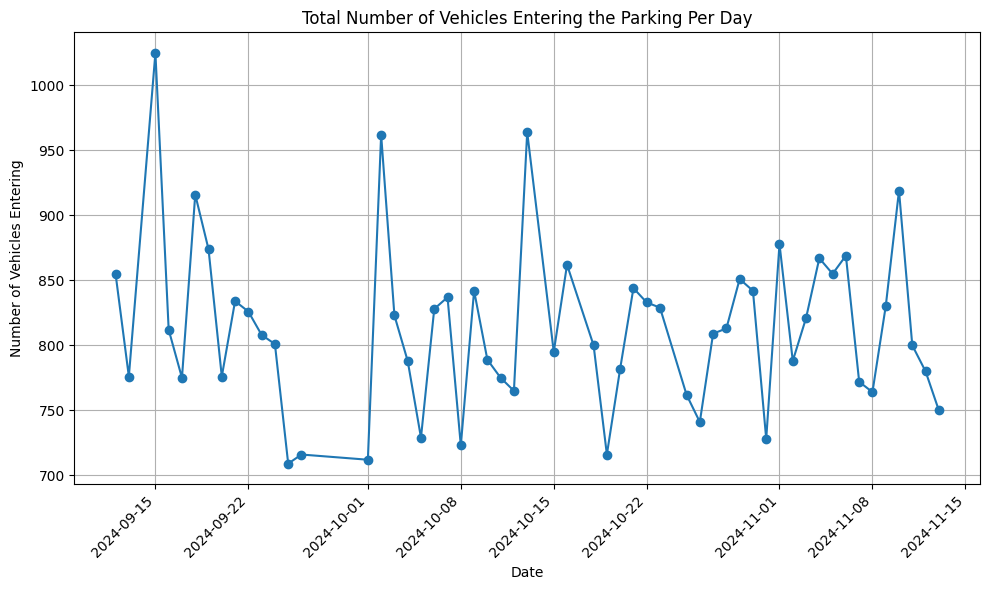

In [315]:

# Group by 'date' and count the number of entries per day
entries_daily = merged_df.groupby('date')['vehicle_no'].count()
entries_daily.index = pd.to_datetime(entries_daily.index)



# Sort the data by date (this step ensures it's chronological)
entries_daily = entries_daily.sort_index()

plt.figure(figsize=(10, 6))
entries_daily.plot(kind='line', marker='o')
plt.title('Total Number of Vehicles Entering the Parking Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()
 


## 1st method backward filling
We can clearly see in the above graph that there are some dates which doesn't have the data for this I used Backward filling for the data.

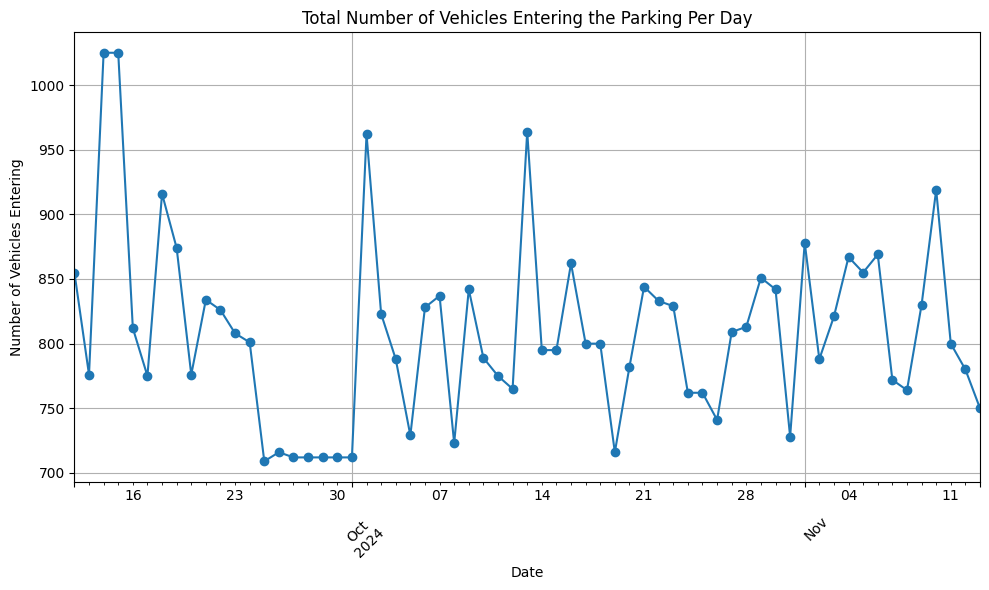

In [316]:
entries_daily = entries_daily.reindex(pd.date_range(start=entries_daily.index.min(), 
                                              end=entries_daily.index.max(), 
                                              freq='D')).fillna(method='bfill')
#  Split the data into train and test sets
# Use all but the last 7 days for training, and the last 7 days for testing
train_data = entries_daily.iloc[:-7]  # All data except the last 7 days
test_data = entries_daily.iloc[-7:]


plt.figure(figsize=(10, 6))
entries_daily.plot(kind='line', marker='o')
plt.title('Total Number of Vehicles Entering the Parking Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()



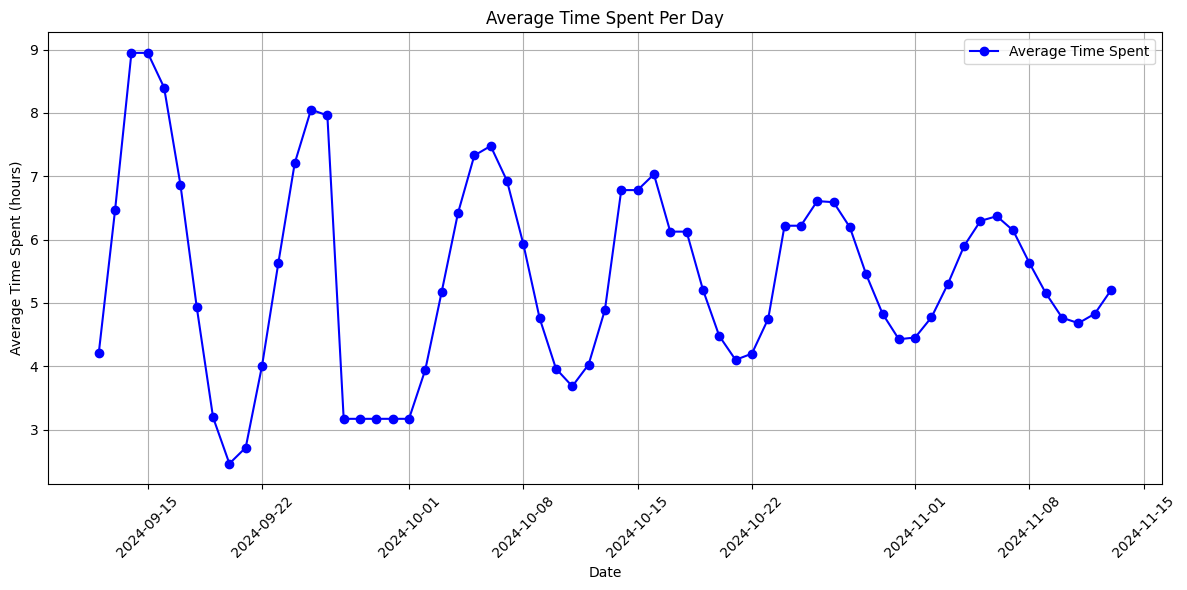

In [317]:
merged_df['time_spent'] = (merged_df['exit_time'] - merged_df['in_time']).dt.total_seconds() / 3600  # convert to hours
avg_time_spent = merged_df.groupby(by=merged_df['in_time'].dt.date)['time_spent'].mean()
y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))
date_range = pd.date_range(start=y_time.index.min(), end=y_time.index.max(), freq='D')
y_time = y_time.reindex(date_range).fillna(method='bfill')


y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)
plt.figure(figsize=(12, 6))
plt.plot(y_time.index, y_time['time_spent'], label="Average Time Spent", color='blue',marker='o')
# Formatting the plot
plt.title('Average Time Spent Per Day')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

These are the functions created by the methods in Part 1 and 2 which we will use for analysisi here.

In [318]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    :param y_true: Array-like, true values
    :param y_pred: Array-like, predicted values
    :return: float, MASE value
    """
    # Calculate the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase

def forecasting_and_plotting_daily_entry(train_data, test_data):
    # ARIMA Model
    model_auto_arima = AutoARIMA(sp=30, suppress_warnings=True, seasonal=True)
    model_auto_arima.fit(train_data)
    forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])
    mase_arima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_auto_arima)
    mape_arima = mean_absolute_percentage_error(test_data, forecast_auto_arima)

    # Exponential Smoothing Model
    exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(test_data, forecast_exp_smoothing)

    # Consolidate forecasts and errors for plotting with distinct colors
    model_forecasts = {
        'Auto ARIMA': (forecast_auto_arima, mape_arima, mase_arima, 'purple'),
        'Exponential Smoothing': (forecast_exp_smoothing, mape_exp_smoothing, mase_exp_smoothing, 'red')
    }

    # Plot combined graph with all models
    plt.figure(figsize=(14, 8))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
    
    for model_name, (forecast, mape, mase, color) in model_forecasts.items():
        plt.plot(test_data.index, forecast, label=f"{model_name} (MAPE: {mape:.2%}, MASE: {mase:.4f})", linestyle='--', color=color)

    plt.title('Forecast Comparison Across Models')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display forecasted values for the next 7 days
    forecast_df = pd.DataFrame({
        'Auto ARIMA': forecast_auto_arima,
        'Exponential Smoothing': forecast_exp_smoothing
    }, index=test_data.index)

    print("Forecasted values for the next 7 days:")
    print(forecast_df)
def predictionTimeSpent(y_train_time,y_test_time):
    
    # Cell 3: AutoARIMA Model Training and Forecasting
    model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
    model_time.fit(y=y_train_time)

    # Forecasting
    y_pred_time = model_time.predict(fh=np.arange(1, 8))

    # Calculate MASE and MAPE for AutoARIMA
    mase_arima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
    mape_arima = mean_absolute_percentage_error(y_test_time, y_pred_time)

    exp_smoothing_model = ExponentialSmoothing(y_train_time, trend='add', seasonal='add', seasonal_periods=7).fit()

    # Forecasting
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)

    # Calculate MASE and MAPE for Exponential Smoothing
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(y_test_time, forecast_exp_smoothing)

    # Print Results
    print("Exponential Smoothing MASE:", mase_exp_smoothing)
    print("Exponential Smoothing MAPE:", mape_exp_smoothing * 100)
    # Cell 7: Visualization of Forecasts
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train_time.index, y_train_time, label="Training Data", color='blue')
    # Plot test data
    plt.plot(y_test_time.index, y_test_time, label="Actual Test Data", color='orange')

    # Plot forecasts from each model
    plt.plot(y_test_time.index, y_pred_time, label="AutoARIMA Forecast", linestyle='--', color='green')
    plt.plot(y_test_time.index, forecast_exp_smoothing, label="Exponential Smoothing Forecast", linestyle='--', color='brown')

    # Adding titles and labels
    plt.title(f'Forecast Comparison\n'
            f'AutoARIMA MAPE: {mape_arima * 100:.2f}%, MASE: {mase_arima:.4f} \n'

            f'Exp Smoothing MAPE: {mape_exp_smoothing * 100:.2f}%, MASE: {mase_exp_smoothing:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


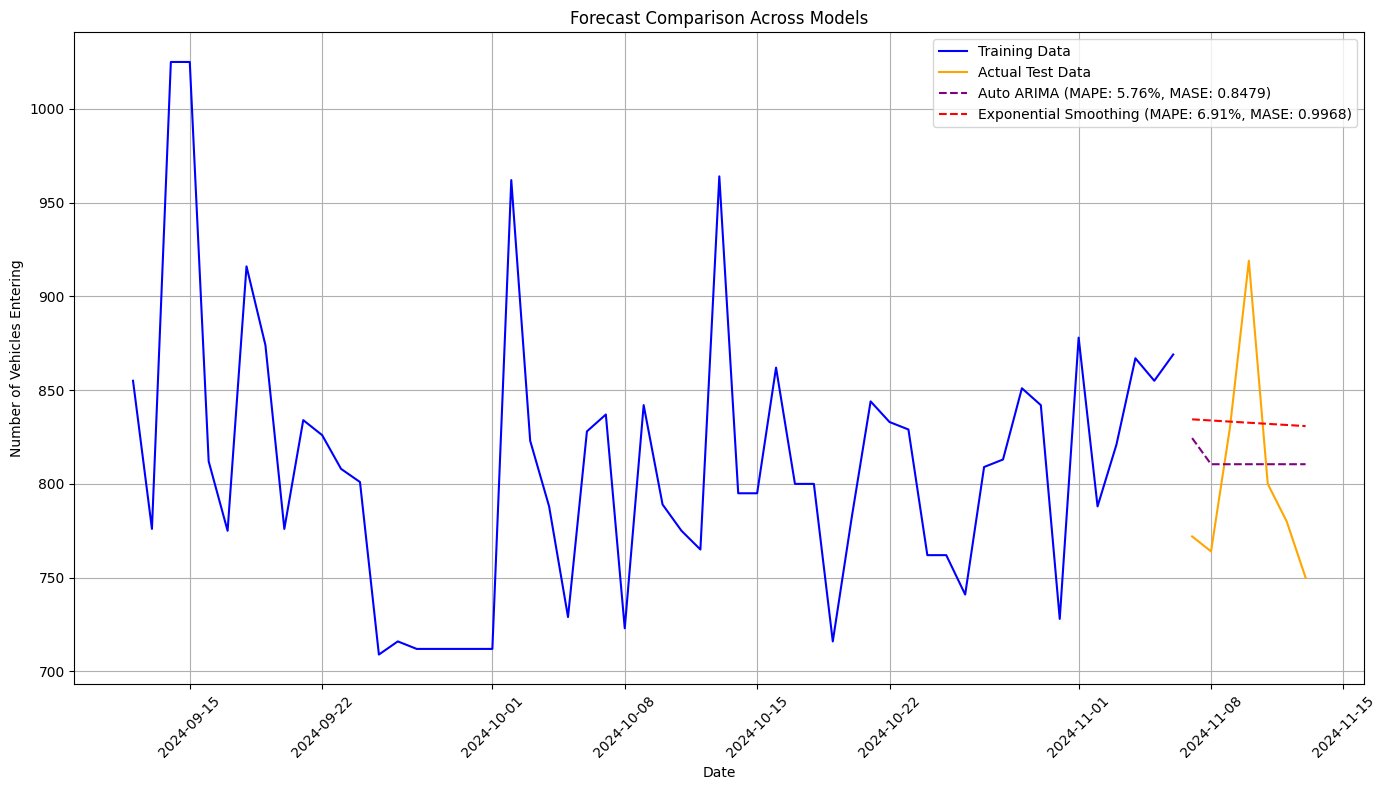

Forecasted values for the next 7 days:
            Auto ARIMA  Exponential Smoothing
2024-11-07  824.430111             834.416961
2024-11-08  810.488686             833.817025
2024-11-09  810.488686             833.217090
2024-11-10  810.488686             832.617155
2024-11-11  810.488686             832.017219
2024-11-12  810.488686             831.417284
2024-11-13  810.488686             830.817349


In [319]:
forecasting_and_plotting_daily_entry(train_data,test_data)

Exponential Smoothing MASE: 3.894290318704536
Exponential Smoothing MAPE: 26.301182877729275


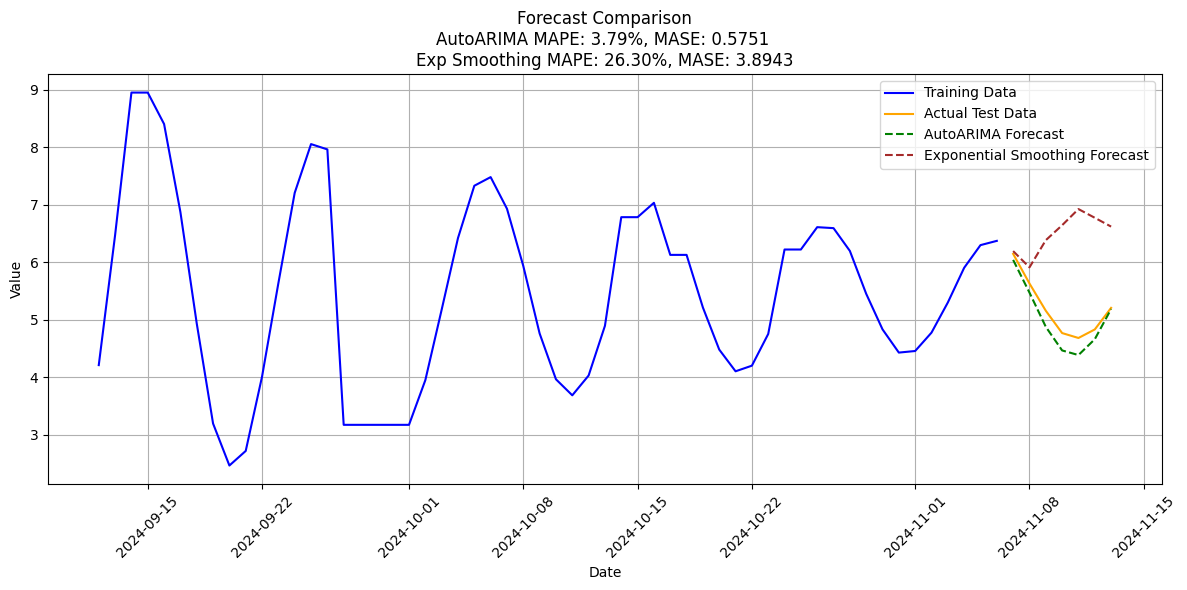

In [320]:
predictionTimeSpent(y_train_time,y_test_time)

# Rolling Mean Smoothing


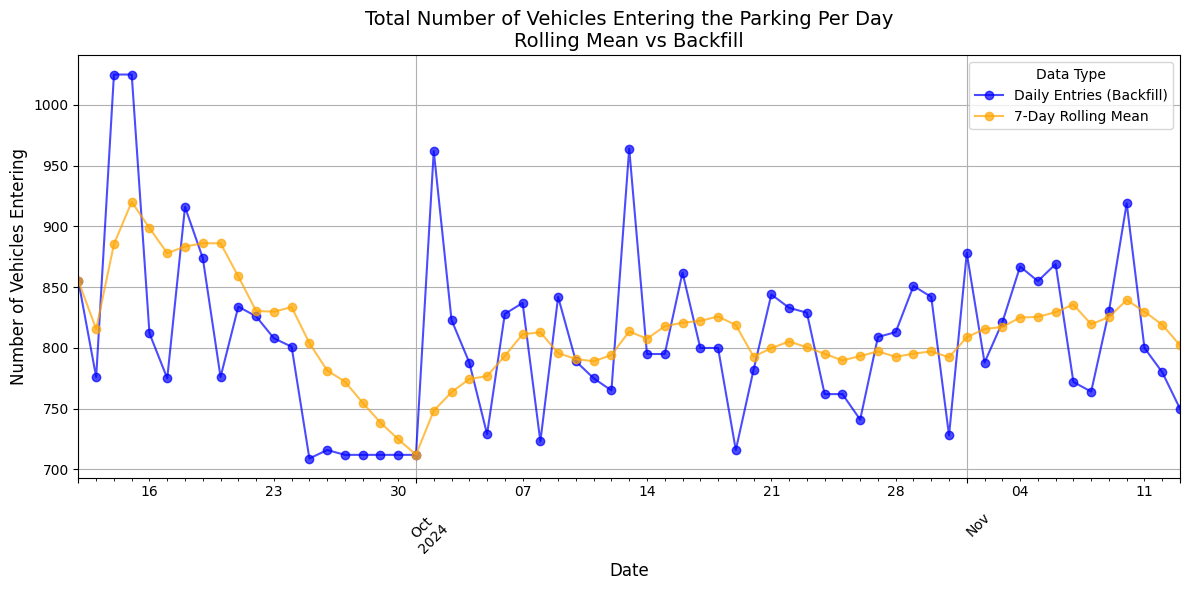

In [321]:
# Calculate rolling mean
rolled = entries_daily.rolling(window=7, min_periods=1).mean()
train_data = rolled.iloc[:-7]  # All data except the last 7 days
test_data = rolled.iloc[-7:]
# Create the plot
plt.figure(figsize=(12, 6))

# Plot original data
entries_daily.plot(kind='line', marker='o', color='blue', label='Daily Entries (Backfill)', alpha=0.7)

# Plot rolled data
rolled.plot(kind='line', marker='o', color='orange', label='7-Day Rolling Mean', alpha=0.7)

# Customize plot
plt.title('Total Number of Vehicles Entering the Parking Per Day\nRolling Mean vs Backfill', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Vehicles Entering', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend(title='Data Type', fontsize=10)  # Add legend with title
plt.tight_layout()

# Show the plot
plt.show()

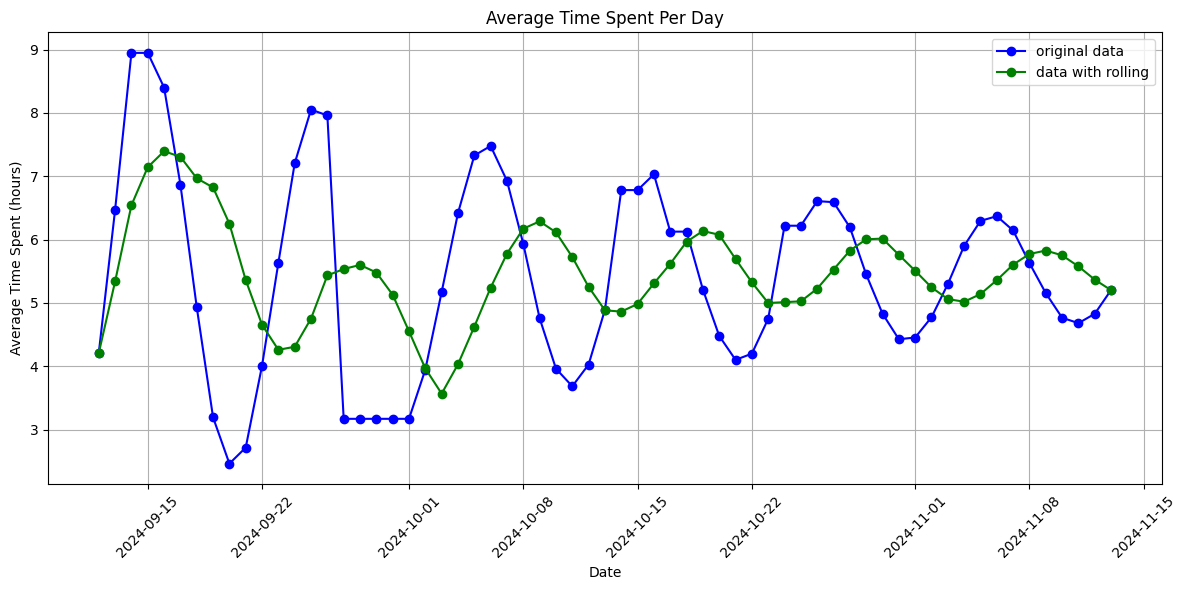

In [322]:

# Calculate the 7-day rolling mean
rolled_time_spent = y_time.rolling(window=7, min_periods=1).mean()

y_train_time, y_test_time = temporal_train_test_split(rolled_time_spent, test_size=7)
plt.figure(figsize=(12, 6))
plt.plot(y_time.index, y_time['time_spent'], label="original data", color='blue',marker='o')
plt.plot(rolled_time_spent.index, rolled_time_spent['time_spent'], label="data with rolling", color='green',marker='o')
# Formatting the plot
plt.title('Average Time Spent Per Day')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

These are the new plots obtained by using the Rolling mean

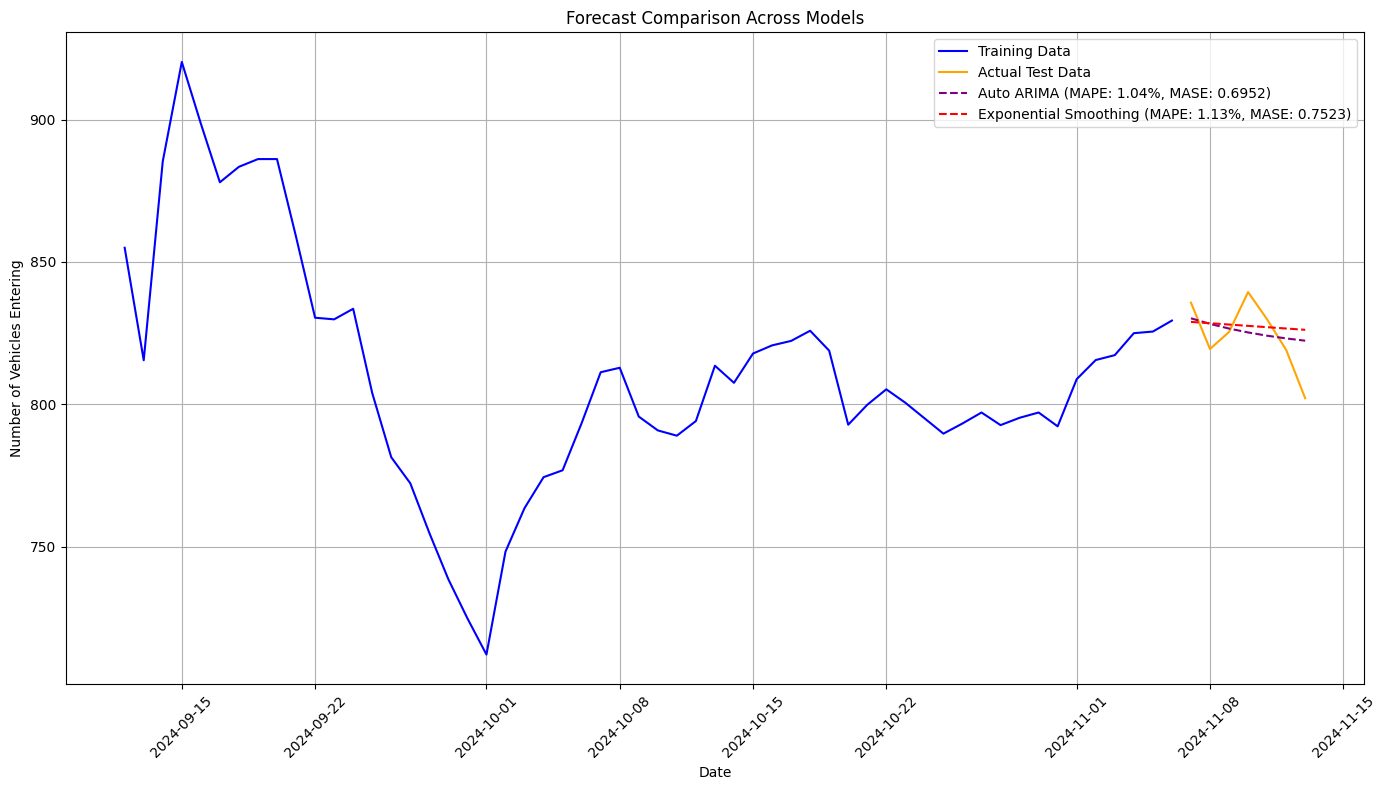

Forecasted values for the next 7 days:
            Auto ARIMA  Exponential Smoothing
2024-11-07  830.222828             828.963997
2024-11-08  828.263840             828.499422
2024-11-09  826.626956             828.034847
2024-11-10  825.259215             827.570272
2024-11-11  824.116364             827.105697
2024-11-12  823.161424             826.641122
2024-11-13  822.363500             826.176547


In [323]:
forecasting_and_plotting_daily_entry(train_data,test_data)

Exponential Smoothing MASE: 1.52914168611556
Exponential Smoothing MAPE: 3.8719514731850055


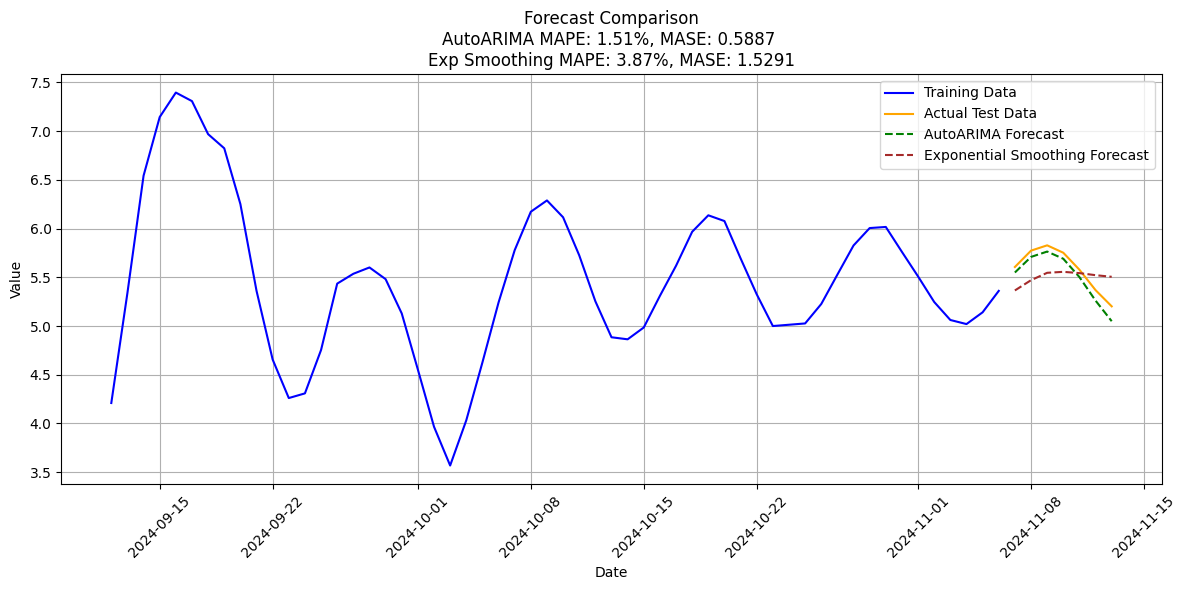

In [324]:
predictionTimeSpent(y_train_time,y_test_time)

## Z Score method
These is a method of outlier removal

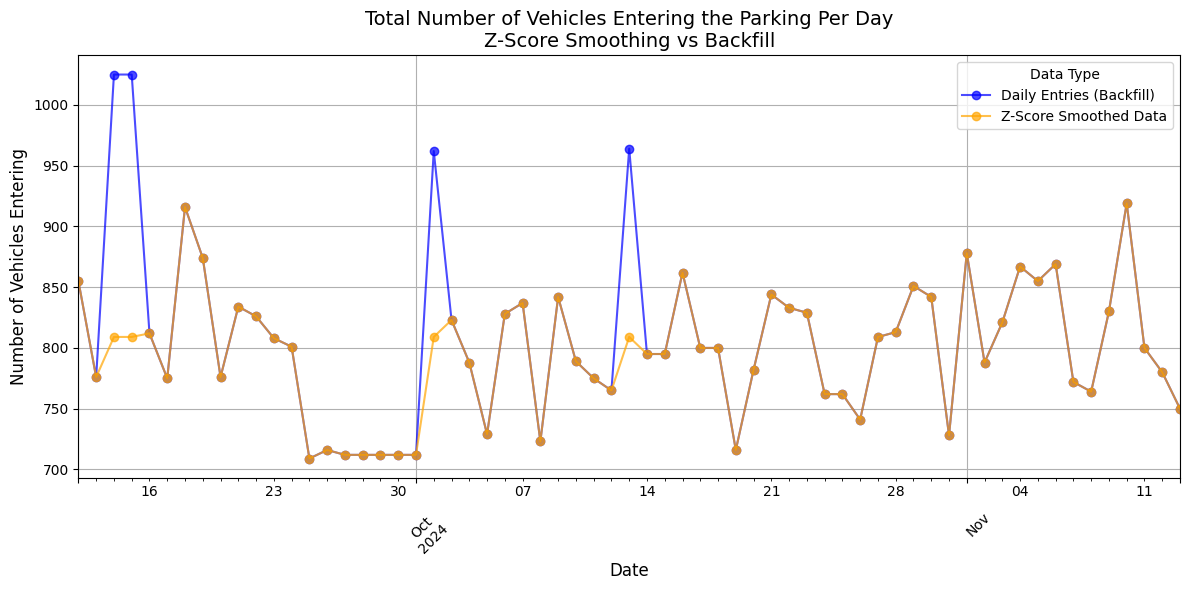

In [325]:
entries_daily = entries_daily.reindex(pd.date_range(start=entries_daily.index.min(), 
                                              end=entries_daily.index.max(), 
                                              freq='D')).fillna(method='bfill')
mean = entries_daily.mean()
std_dev = entries_daily.std()
threshold = 2  # You can adjust this threshold

# Identify outliers
zscore = (entries_daily - mean) / std_dev
smoothed = pd.Series(np.where(np.abs(zscore) > threshold, mean, entries_daily), 
                     index=entries_daily.index)
train_data = smoothed.iloc[:-7]  # All data except the last 7 days
test_data = smoothed.iloc[-7:]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot original data
entries_daily.plot(kind='line', marker='o', color='blue', label='Daily Entries (Backfill)', alpha=0.7)

# Plot smoothed data
smoothed.plot(kind='line', marker='o', color='orange', label='Z-Score Smoothed Data', alpha=0.7)

# Customize plot
plt.title('Total Number of Vehicles Entering the Parking Per Day\nZ-Score Smoothing vs Backfill', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Vehicles Entering', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend(title='Data Type', fontsize=10)  # Add legend with title
plt.tight_layout()

# Show the plot
plt.show()

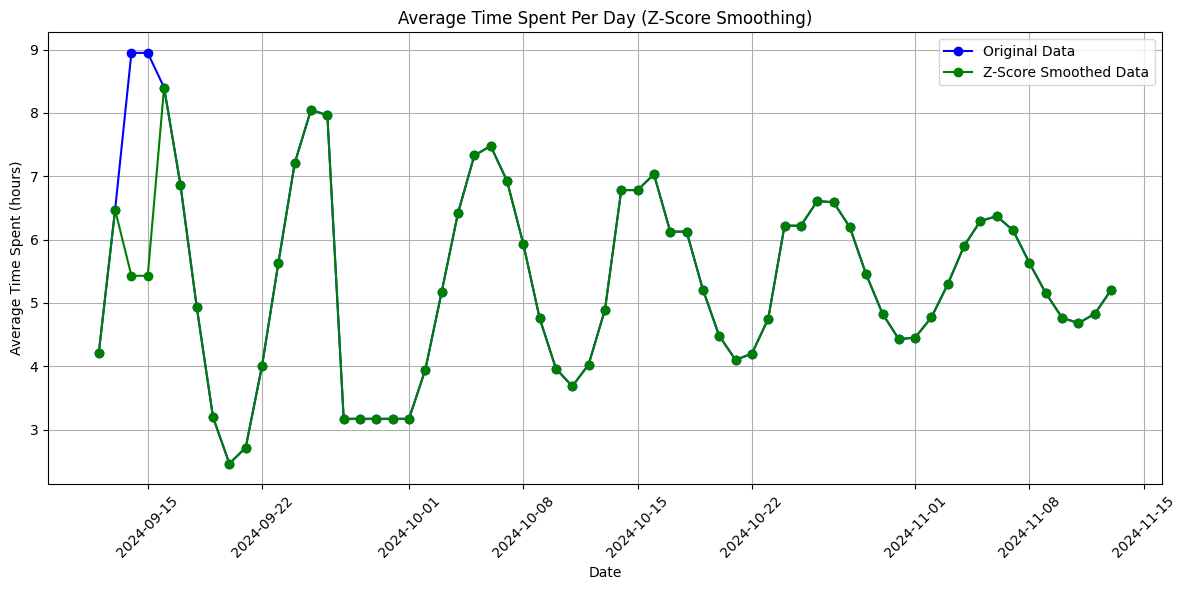

In [326]:
mean_time_spent = y_time.mean()
std_time_spent = y_time.std()
threshold = 2  # Z-score threshold

# Calculate Z-scores
z_scores = (y_time - mean_time_spent) / std_time_spent

# Smooth data by replacing outliers
smoothed_time_spent = np.where(np.abs(z_scores) > threshold, mean_time_spent, y_time)

# Create a new DataFrame for the smoothed data to maintain the same structure
smoothed_df = pd.DataFrame(data=smoothed_time_spent, index=y_time.index, columns=['smoothed_time_spent'])

# Split the data for training and testing
y_train_time, y_test_time = temporal_train_test_split(smoothed_df, test_size=7)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_time.index, y_time['time_spent'], label="Original Data", color='blue', marker='o')
plt.plot(smoothed_df.index, smoothed_df['smoothed_time_spent'], label="Z-Score Smoothed Data", color='green', marker='o')

# Formatting the plot
plt.title('Average Time Spent Per Day (Z-Score Smoothing)')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

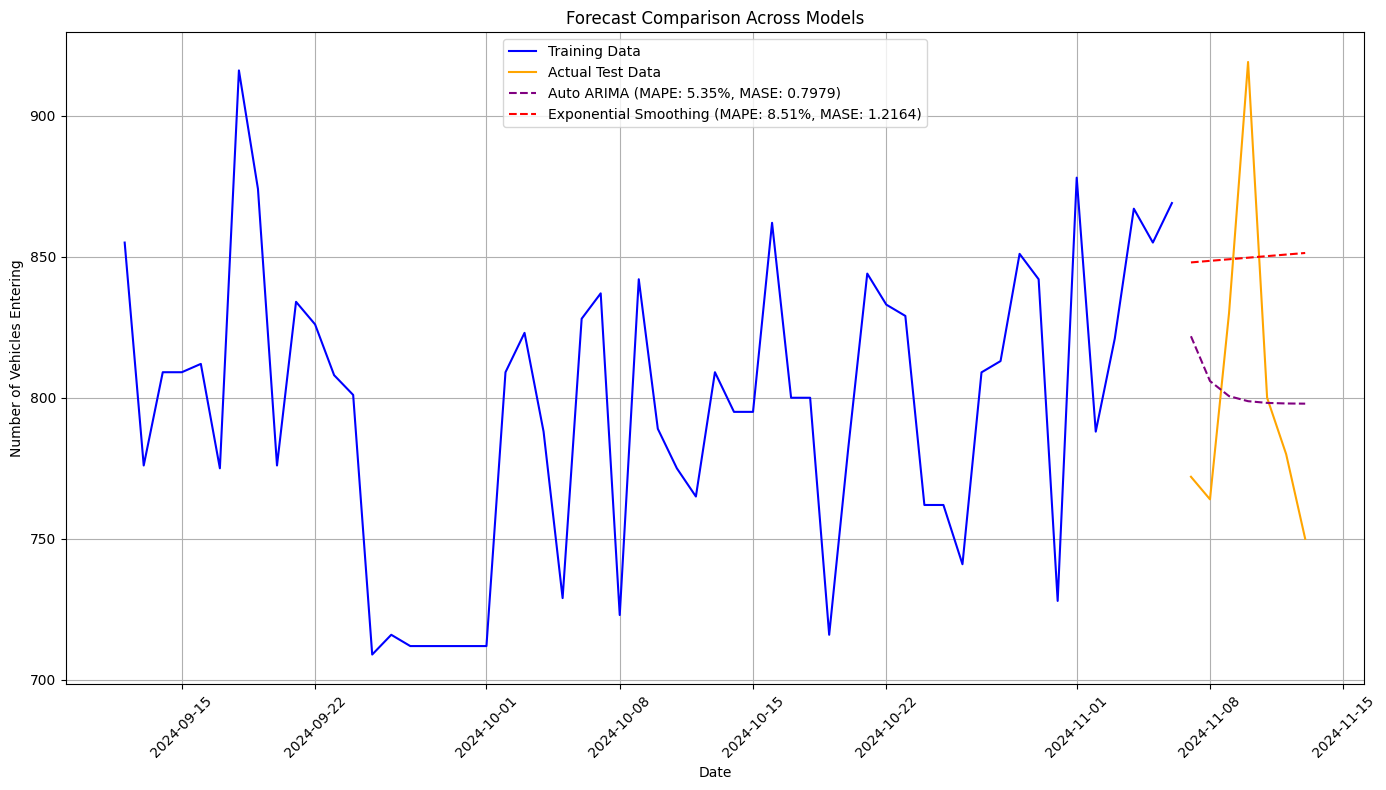

Forecasted values for the next 7 days:
            Auto ARIMA  Exponential Smoothing
2024-11-07  821.795541             847.960580
2024-11-08  805.918124             848.517951
2024-11-09  800.577688             849.075323
2024-11-10  798.781410             849.632694
2024-11-11  798.177224             850.190065
2024-11-12  797.974004             850.747436
2024-11-13  797.905650             851.304808


In [327]:
forecasting_and_plotting_daily_entry(train_data,test_data)

Exponential Smoothing MASE: 3.5146551069176977
Exponential Smoothing MAPE: 23.763670622415724


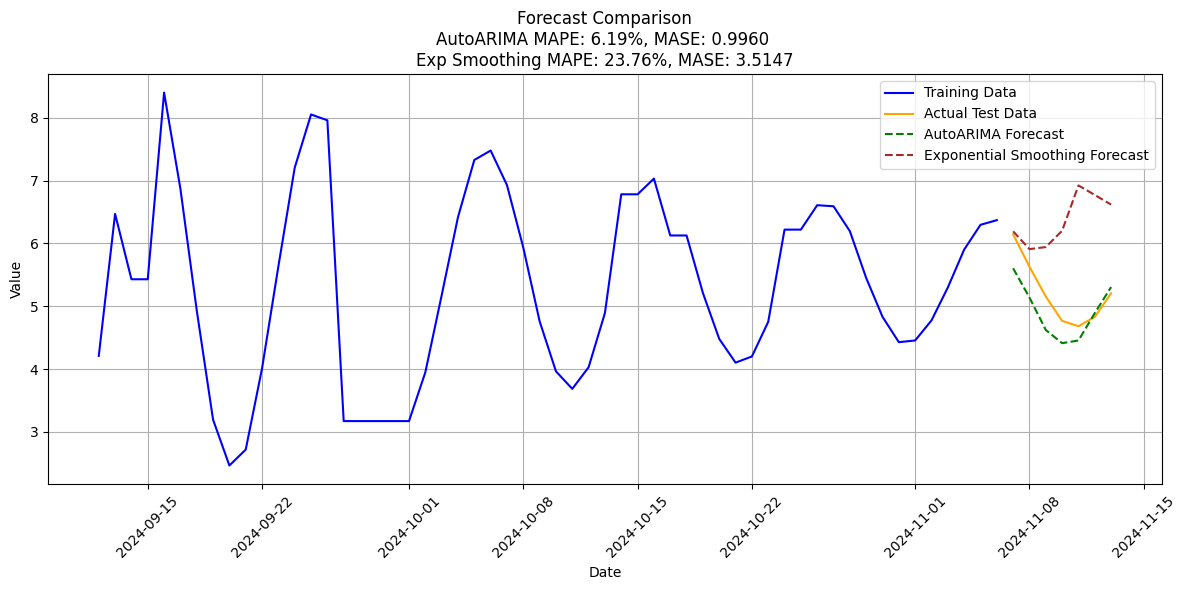

In [328]:
predictionTimeSpent(y_train_time,y_test_time)